In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math
from itertools import combinations
import matplotlib.pyplot as plt

# A. Explore relationship betwen forex pair movements etc yada yada

OK so this is not exaclty forex pairs because it seems to be a pain in the ass to find one, but i think the intuition for this one is quite solid

1. SGD is pegged against a basket of currencies (S$NEER), https://www.mas.gov.sg/monetary-policy/past-monetary-policy-decisions
2. DXY is an index that measures the USD value relative to a basket of currencies https://www.investopedia.com/terms/u/usdx.asp

fucking money laundering ccy

Essentially this is basket meet basket kind of thing. "ETF" pairs trading if you will.

USD-SGD is tradeable, and so is DXY. Prof Ben say pairs trading does not have to be same asset class, so this COULD be legit

Anyway general steps 

1. test your series (plural) are cointegrated or not
2. test your spread is stationary or not
3. generate trading signal

Possible improvement can be done for the regression part to obtain the weights. Right now we are using OLS and probably can be changed

In [2]:
start_date = "2023-01-01"
end_date = "2024-05-31"
item1 = "USDSGD=X"
item2 = "DX-Y.NYB"
train_ratio = 0.8

In [3]:
# get close data
item1 = "USDSGD=X"
item1_data = yf.Ticker(item1).history(start=start_date, end=end_date, interval="1h")[
    "Close"
]
item2_data = yf.Ticker(item2).history(start=start_date, end=end_date, interval="1h")[
    "Close"
]

# align indices
if len(item2_data) > len(item1_data):
    myindex = item1_data.index
else:
    myindex = item2_data.index

# zip together data frame
df_together = pd.DataFrame(
    zip(item1_data, item2_data),
    index=myindex,
    columns=[item1, item2],
)

# prepare return frame
return_df = (df_together / df_together.shift(1)) - 1

# prepare data for train and out of sample
train_start = 0
train_end = math.floor(train_ratio * len(df_together))
oos_start = train_end + 1
oos_end = len(df_together) - 1

# yea these are it
splitidx = df_together.iloc[train_end].name
training = df_together[train_start:train_end]
oos = df_together[oos_start:oos_end]

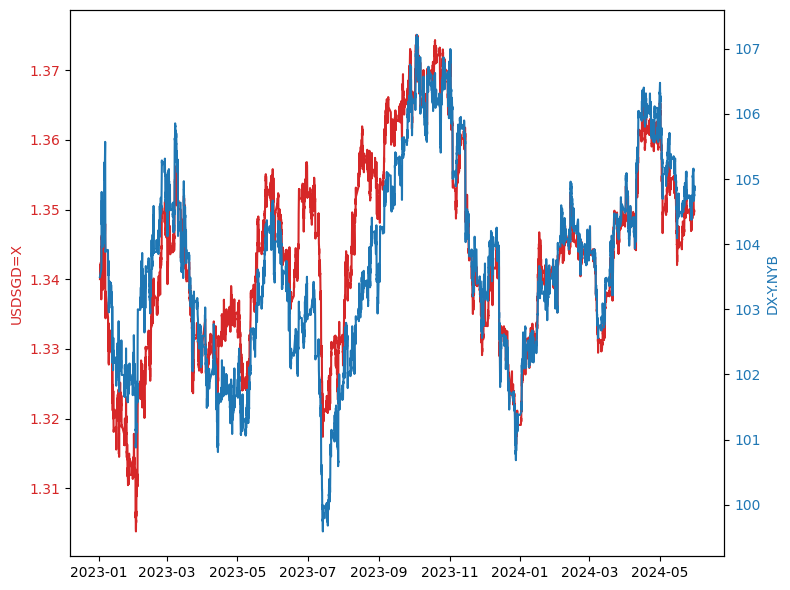

In [4]:
fig, ax1 = plt.subplots(figsize=(8, 6))
color = "tab:red"
ax1.set_ylabel(item1, color=color)
ax1.plot(item1_data, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel(item2, color=color)
ax2.plot(item2_data, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Test for Cointegration
Using the ts.coint function, we are using the Engle-Gragner test
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html

I think the way to read the result is you compare tour test statistic with the crit values. 

If your test statistic is smaller than the crit value for that significance level, then your series (plural) are cointegrated up to that significance level

e.g. test statistic = -3.5, crit value for 5% significance = -3.3
your series(plural) are coint with 5% significance level

In [5]:
# lets do it
coint_result = ts.coint(training[item1], training[item2])
print("************ COINT TEST ON TRAINING SUBSET ************")
print(f"test statistic = {coint_result[0]}")
print(
    f"crit values (from left to right 1%, 5%, 10% significance level)= {coint_result[2]}"
)
print("************ END COINT TEST ************")

************ COINT TEST ON TRAINING SUBSET ************
test statistic = -4.590905930979723
crit values (from left to right 1%, 5%, 10% significance level)= [-3.89805059 -3.3370283  -3.04507349]
************ END COINT TEST ************


### Regression and Note regarding stationarity test

if your test statistic is smaller than critical value for a corresponding significance level, means your series is stationary up to that significance level

e.g. test_statistic = -3.5, 1% significance critval = - 3.3 
your series is stationary with significane level of 99%

another thing to check is p value
p value > 0.05 ; accept null & your series is NOT stationary
p value < 0.05 ; reject null hypothesis & your series IS STATIONARY

************ ADF TEST ON TRAINING SUBSET ************
test statistic -4.590587771658877
p value 0.0001344289743548039
critical values for test statistic {'1%': -3.4313130167517363, '5%': -2.861965573996229, '10%': -2.5669965292969104}
regression param; gamma : 0.0069997390553181195 ; mu : 0.6180825569226762
************ END ADF TEST ************


C:\Users\kilo\AppData\Local\Temp\ipykernel_5164\3411221783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training["spread"] = y - gamma * x


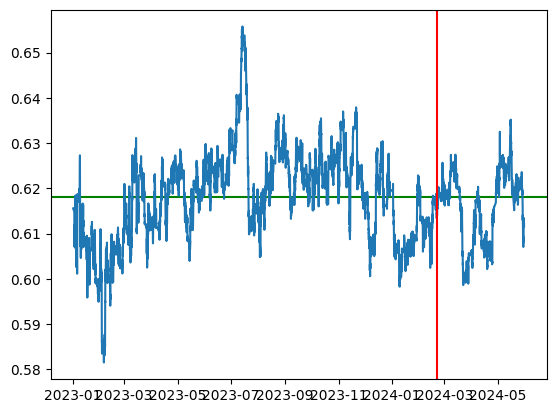

In [6]:
y = training[item1]  # usdsgd
x = training[item2]  # dxy
result = sm.OLS(y.to_numpy(), sm.tools.add_constant(x.to_numpy())).fit()

mu = result.params[0]
gamma = result.params[1]
# print model vs actual
training["spread"] = y - gamma * x
model = gamma * x + mu

# spread, idk why prof ben coded it like this
y_all = df_together[item1]  # usdsgd
x_all = df_together[item2]  # dxy

result_adf = ts.adfuller(training["spread"])
print("************ ADF TEST ON TRAINING SUBSET ************")
print(f"test statistic {result_adf[0]}")
print(f"p value {result_adf[1]}")
print(f"critical values for test statistic {result_adf[4]}")
print(f"regression param; gamma : {gamma} ; mu : {mu}")
print("************ END ADF TEST ************")

df_together["spread"] = y_all - gamma * x_all
plt.axhline(np.mean(y - gamma * x), color="green")
plt.plot(df_together["spread"])
plt.axvline(splitidx, color="red")
plt.show()

## ok now we actually do the portfolio

https://palomar.home.ece.ust.hk/MAFS5310_lectures/Rsession_pairs_trading_with_R.html

In [7]:
normport = [1, -gamma] / (1 + gamma)
df_together_weighted = normport * df_together[[item1, item2]]
df_together_weighted["spread"] = (
    df_together_weighted[item1] + df_together_weighted[item2]
)

weight_train_mean = np.mean(df_together_weighted[train_start:train_end]["spread"])
weight_train_std = np.std(
    df_together_weighted[train_start:train_end]["spread"],
    ddof=1,
)

Spread from normalzied portfolio

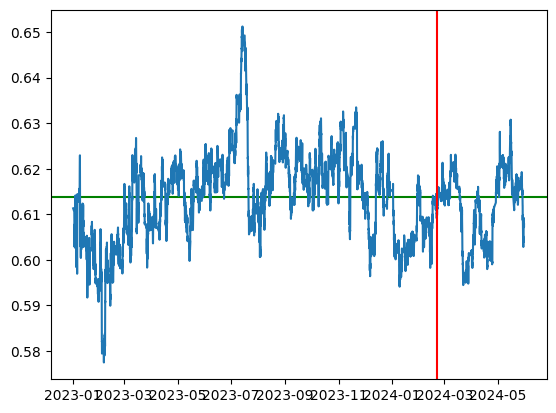

In [8]:
plt.axhline(weight_train_mean, color="green")
plt.plot(df_together_weighted["spread"])
plt.axvline(splitidx, color="red")

Setup thresholds when to long and short

In [9]:
thresh_list = [-1, 1]
thresh_short = thresh_list[1]
thresh_long = thresh_list[0]
print(f"short thresh {thresh_short} ; long thresh {thresh_long}")

short thresh 1 ; long thresh -1


In [10]:
# construct Z score to build port
df_z = (df_together_weighted["spread"] - weight_train_mean) / weight_train_std
df_z = df_z.to_frame()
df_z.reset_index(inplace=True)

first row do nothing


C:\Users\kilo\AppData\Local\Temp\ipykernel_5164\4264552597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_z["position"].iloc[0] = 0
C:\Users\kilo\AppData\Local\Temp\ipykernel_5164\4264552597.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_z["position"].loc[idx] = df_z["position"].loc[idx - 1]
C:\Users\kilo\AppData\Local\Temp\ipykernel_5164\4264552597.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_z["position"].

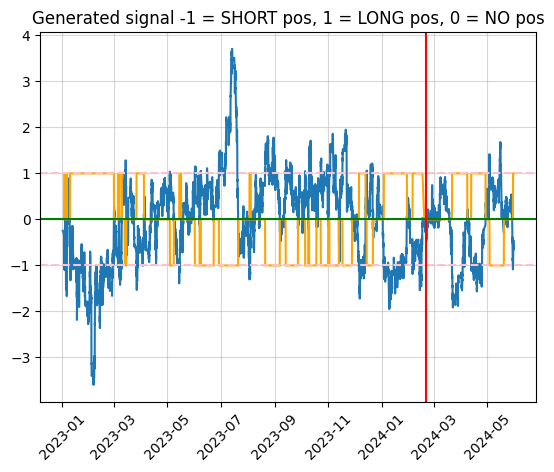

In [11]:
# now actually signal
df_z["position"] = np.nan
df_z.head(10)
# initial position
df_z["position"].iloc[0] = 0
if df_z["spread"].iloc[0] < thresh_long:
    df_z["position"].iloc[0] = 1
elif df_z["spread"].iloc[0] >= thresh_short:
    df_z["position"].iloc[0] = -1

for idx, row in df_z.iterrows():
    if idx == 0:
        print("first row do nothing")
    else:
        if df_z["position"].loc[idx - 1] == 0:  # no position
            if df_z["spread"].loc[idx] < thresh_long:
                df_z["position"].loc[idx] = 1
            elif df_z["spread"].loc[idx] > thresh_short:
                df_z["position"].loc[idx] = -1
            else:
                df_z["position"].loc[idx] = df_z["position"].loc[idx - 1]
        elif df_z["position"].loc[idx - 1] == 1:  # ure long
            if df_z["spread"].loc[idx] > 0:
                df_z["position"].loc[idx] = 0  # close it
            else:
                df_z["position"].loc[idx] = df_z["position"].loc[idx - 1]
        elif df_z["position"].loc[idx - 1] == -1:  # ure shorte
            if df_z["spread"].loc[idx] < 0:
                df_z["position"].loc[idx] = 0  # close it
            else:
                df_z["position"].loc[idx] = df_z["position"].loc[idx - 1]

df_z["position"] = df_z["position"].shift(1)
plt.plot(df_z["Datetime"], df_z["spread"])
plt.plot(df_z["Datetime"], df_z["position"], color="orange")
plt.grid(alpha=0.5)
plt.title("Generated signal -1 = SHORT pos, 1 = LONG pos, 0 = NO pos")
plt.axhline(0, color="green")
plt.axhline(thresh_short, color="pink", linestyle="dashed")
plt.axhline(thresh_long, color="pink", linestyle="dashed")
plt.axvline(splitidx, color="red")
plt.xticks(rotation=45)
plt.show()

In [12]:
# PnL calcs
df_together_weighted["return"] = df_together_weighted["spread"].diff()
df_together_weighted["position"] = df_z["position"].to_numpy()
df_together_weighted["traded_return"] = df_together_weighted[
    "return"
] * df_together_weighted["position"].shift(1)
df_together_weighted["traded_return_cumsum"] = df_together_weighted[
    "traded_return"
].cumsum()
index_for_pnl = df_z["Datetime"]

df_together_weighted[f"{item1}_ratio"] = df_together_weighted["position"] * normport[0]
df_together_weighted[f"{item2}_ratio"] = df_together_weighted["position"] * normport[1]

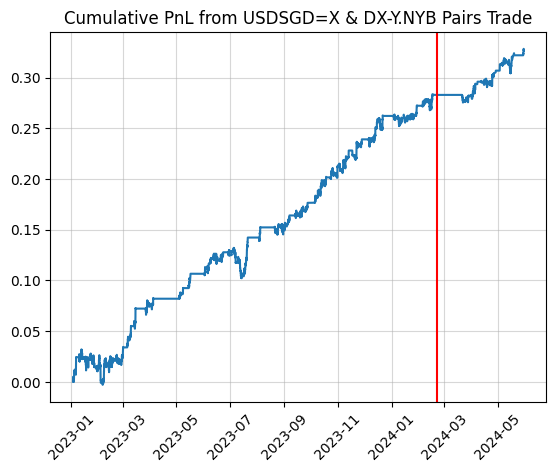

In [13]:
plt.title(f"Cumulative PnL from {item1} & {item2} Pairs Trade")
plt.grid(alpha=0.5)
plt.plot(index_for_pnl, df_together_weighted["traded_return_cumsum"])
plt.axvline(splitidx, color="red")
plt.xticks(rotation=45)
plt.show()

## Does This Pair still hold?

Test for pair breakage, shift the window to include the OOS sample now

In [14]:
# just now 80% train 20% oos, so now i just shift the data, ignore the first 20%
retest_start = math.floor((1 - train_ratio) * len(df_together))
retest = df_together[retest_start:-1]

In [15]:
# lets do it
coint_result = ts.coint(retest[item1], retest[item2])
print("************ COINT TEST ON TRAINING SUBSET ************")
print(f"test statistic = {coint_result[0]}")
print(
    f"crit values (from left to right 1%, 5%, 10% significance level)= {coint_result[2]}"
)
print("************ END COINT TEST ************")

************ COINT TEST ON TRAINING SUBSET ************
test statistic = -4.075041110725832
crit values (from left to right 1%, 5%, 10% significance level)= [-3.89805059 -3.3370283  -3.04507349]
************ END COINT TEST ************


In [16]:
y_retest = retest[item1]  # usdsgd
x_retest = retest[item2]  # dxy
result = sm.OLS(y.to_numpy(), sm.tools.add_constant(x.to_numpy())).fit()

mu_retest = result.params[0]
gamma_retest = result.params[1]
# print model vs actual
retest["spread"] = y_retest - gamma_retest * x_retest
model_retest = gamma_retest * x_retest + mu_retest

result_adf_retest = ts.adfuller(retest["spread"])
print("************ ADF TEST ON RETEST SUBSET ************")
print(f"test statistic {result_adf_retest[0]}")
print(f"p value {result_adf_retest[1]}")
print(f"critical values for test statistic {result_adf_retest[4]}")
print(f"regression param; gamma : {gamma_retest} ; mu : {mu_retest}")
print("************ END ADF TEST ************")

************ ADF TEST ON RETEST SUBSET ************
test statistic -4.227019894672097
p value 0.0005928411760521923
critical values for test statistic {'1%': -3.431312166584914, '5%': -2.8619651983534067, '10%': -2.566996329335048}
regression param; gamma : 0.0069997390553181195 ; mu : 0.6180825569226762
************ END ADF TEST ************


C:\Users\kilo\AppData\Local\Temp\ipykernel_5164\2699727946.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retest["spread"] = y_retest - gamma_retest * x_retest


In [17]:
print("************ ADF TEST ON TRAINING SUBSET ************")
print(f"test statistic {result_adf[0]}")
print(f"p value {result_adf[1]}")
print(f"critical values for test statistic {result_adf[4]}")
print(f"regression param; gamma : {gamma} ; mu : {mu}")
print("************ END ADF TEST ************")

************ ADF TEST ON TRAINING SUBSET ************
test statistic -4.590587771658877
p value 0.0001344289743548039
critical values for test statistic {'1%': -3.4313130167517363, '5%': -2.861965573996229, '10%': -2.5669965292969104}
regression param; gamma : 0.0069997390553181195 ; mu : 0.6180825569226762
************ END ADF TEST ************
